In [1]:
import os.path

import torch
from torch import nn, optim

import numpy as np

% matplotlib inline
import matplotlib.pyplot as plt

from cifar10_cnn import *
from utils import *

In [2]:
DISABLE_CUDA = False

if not DISABLE_CUDA and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
dataset = CIFAR10(
    os.path.join(*'data/cifar-10-batches-py'.split('/')),
    batch_size=32, val_size=.2
)

In [4]:
model = load_model(cifar10_model(), os.path.join('models', 'cifar10.pt'), device)

model.eval()
test_accuracy = 0

with torch.no_grad():
    for X, y, label in dataset.test_loader:
        X = X.to(device); y = y.to(device)

        pred = model(X)
        test_accuracy += (torch.argmax(pred, 1) == y).sum()

test_accuracy = test_accuracy.item() / dataset.test_size

print('Test accuracy: %.3f' % test_accuracy)
print('Test error rate: %.3f' % (1 - test_accuracy))

Test accuracy: 0.823
Test error rate: 0.177


Epoch 001: train_loss = 2058.665, val_loss = 2034.860
Epoch 002: train_loss = 2001.903, val_loss = 1986.311
Epoch 003: train_loss = 1984.472, val_loss = 1947.755
Epoch 004: train_loss = 1971.996, val_loss = 1941.964
Epoch 005: train_loss = 1962.949, val_loss = 1924.574
Epoch 006: train_loss = 1955.203, val_loss = 1921.225
Epoch 007: train_loss = 1949.464, val_loss = 1912.517
Epoch 008: train_loss = 1943.899, val_loss = 1903.126
Epoch 009: train_loss = 1940.568, val_loss = 1901.221
Epoch 010: train_loss = 1937.202, val_loss = 1899.200
Epoch 011: train_loss = 1934.349, val_loss = 1892.062
Epoch 012: train_loss = 1931.282, val_loss = 1890.701
Epoch 013: train_loss = 1929.220, val_loss = 1888.333
Epoch 014: train_loss = 1927.712, val_loss = 1887.146
Epoch 015: train_loss = 1926.256, val_loss = 1884.172
Epoch 016: train_loss = 1924.914, val_loss = 1882.364
Epoch 017: train_loss = 1923.418, val_loss = 1881.502
Epoch 018: train_loss = 1922.479, val_loss = 1882.210
Epoch 019: train_loss = 1921

Epoch 153: train_loss = 1895.864, val_loss = 1868.563
Epoch 154: train_loss = 1895.885, val_loss = 1868.273
Epoch 155: train_loss = 1896.053, val_loss = 1867.004
Epoch 156: train_loss = 1895.847, val_loss = 1867.334
Epoch 157: train_loss = 1895.801, val_loss = 1867.974
Epoch 158: train_loss = 1895.872, val_loss = 1867.348
Epoch 159: train_loss = 1895.452, val_loss = 1868.305
Epoch 160: train_loss = 1895.696, val_loss = 1868.224
Epoch 161: train_loss = 1895.618, val_loss = 1868.772
Epoch 162: train_loss = 1895.221, val_loss = 1867.710
Epoch 163: train_loss = 1895.654, val_loss = 1869.085
Epoch 164: train_loss = 1895.692, val_loss = 1867.355
Epoch 165: train_loss = 1895.758, val_loss = 1869.439
Epoch 166: train_loss = 1895.390, val_loss = 1867.285
Epoch 167: train_loss = 1895.360, val_loss = 1867.412
Epoch 168: train_loss = 1895.652, val_loss = 1868.500
Epoch 169: train_loss = 1895.384, val_loss = 1870.209
Epoch 170: train_loss = 1895.346, val_loss = 1868.360
Epoch 171: train_loss = 1895

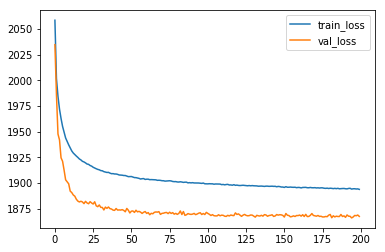

In [5]:
emb_dim = 100
N_EPOCHS = 200

vae = ConvVAE(emb_dim).to(device)
model_path = os.path.join('models', 'conv_vae_cifar10.pt')

optimizer = optim.Adam(vae.parameters(), lr=1e-4)

train_losses = []
val_losses = []

# Train model
for epoch in range(1, N_EPOCHS + 1):
    vae.train()
    
    train_loss = 0
    
    for X, _, _ in dataset.train_loader:
        X = X.to(device)
        
        optimizer.zero_grad()
        recon_X, mu, logvar, code = vae(X)
        
        loss = vae.loss(recon_X, X, mu, logvar)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    train_loss /= dataset.train_size
    train_losses.append(train_loss)
    
    
    vae.eval()
    
    val_loss = 0
    
    with torch.no_grad():
        for X, _, _ in dataset.val_loader:
            X = X.to(device)

            optimizer.zero_grad()
            recon_X, mu, logvar, code = vae(X)
            loss = vae.loss(recon_X, X, mu, logvar)

            val_loss += loss.item()
        
    val_loss /= dataset.val_size
    val_losses.append(val_loss)
    
    print('Epoch %.3d: train_loss = %.3f, val_loss = %.3f' % (
        epoch, train_loss, val_loss
    ))
    

plt.plot(torch.Tensor(train_losses).cpu().detach().numpy(), label='train_loss')
plt.plot(torch.Tensor(val_losses).cpu().detach().numpy(), label='val_loss')
plt.legend();

In [15]:
torch.save(vae.state_dict(), model_path)

In [7]:
emb_dim = 100

vae = ConvVAE(emb_dim).to(device)
model_path = os.path.join('models', 'conv_vae_cifar10.pt')
vae.load_state_dict(torch.load(model_path))

vae = vae.eval()

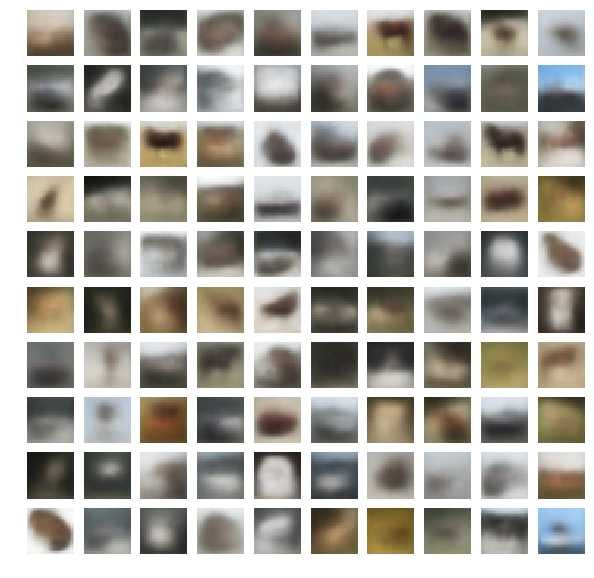

In [8]:
axes = subplots(10, 10, plot_size=1).flatten()

code = torch.randn(len(axes), emb_dim).to(device)
decoded = vae.decode(code)

for ax, img in zip(axes, decoded):
    imshow(img.detach(), ax)

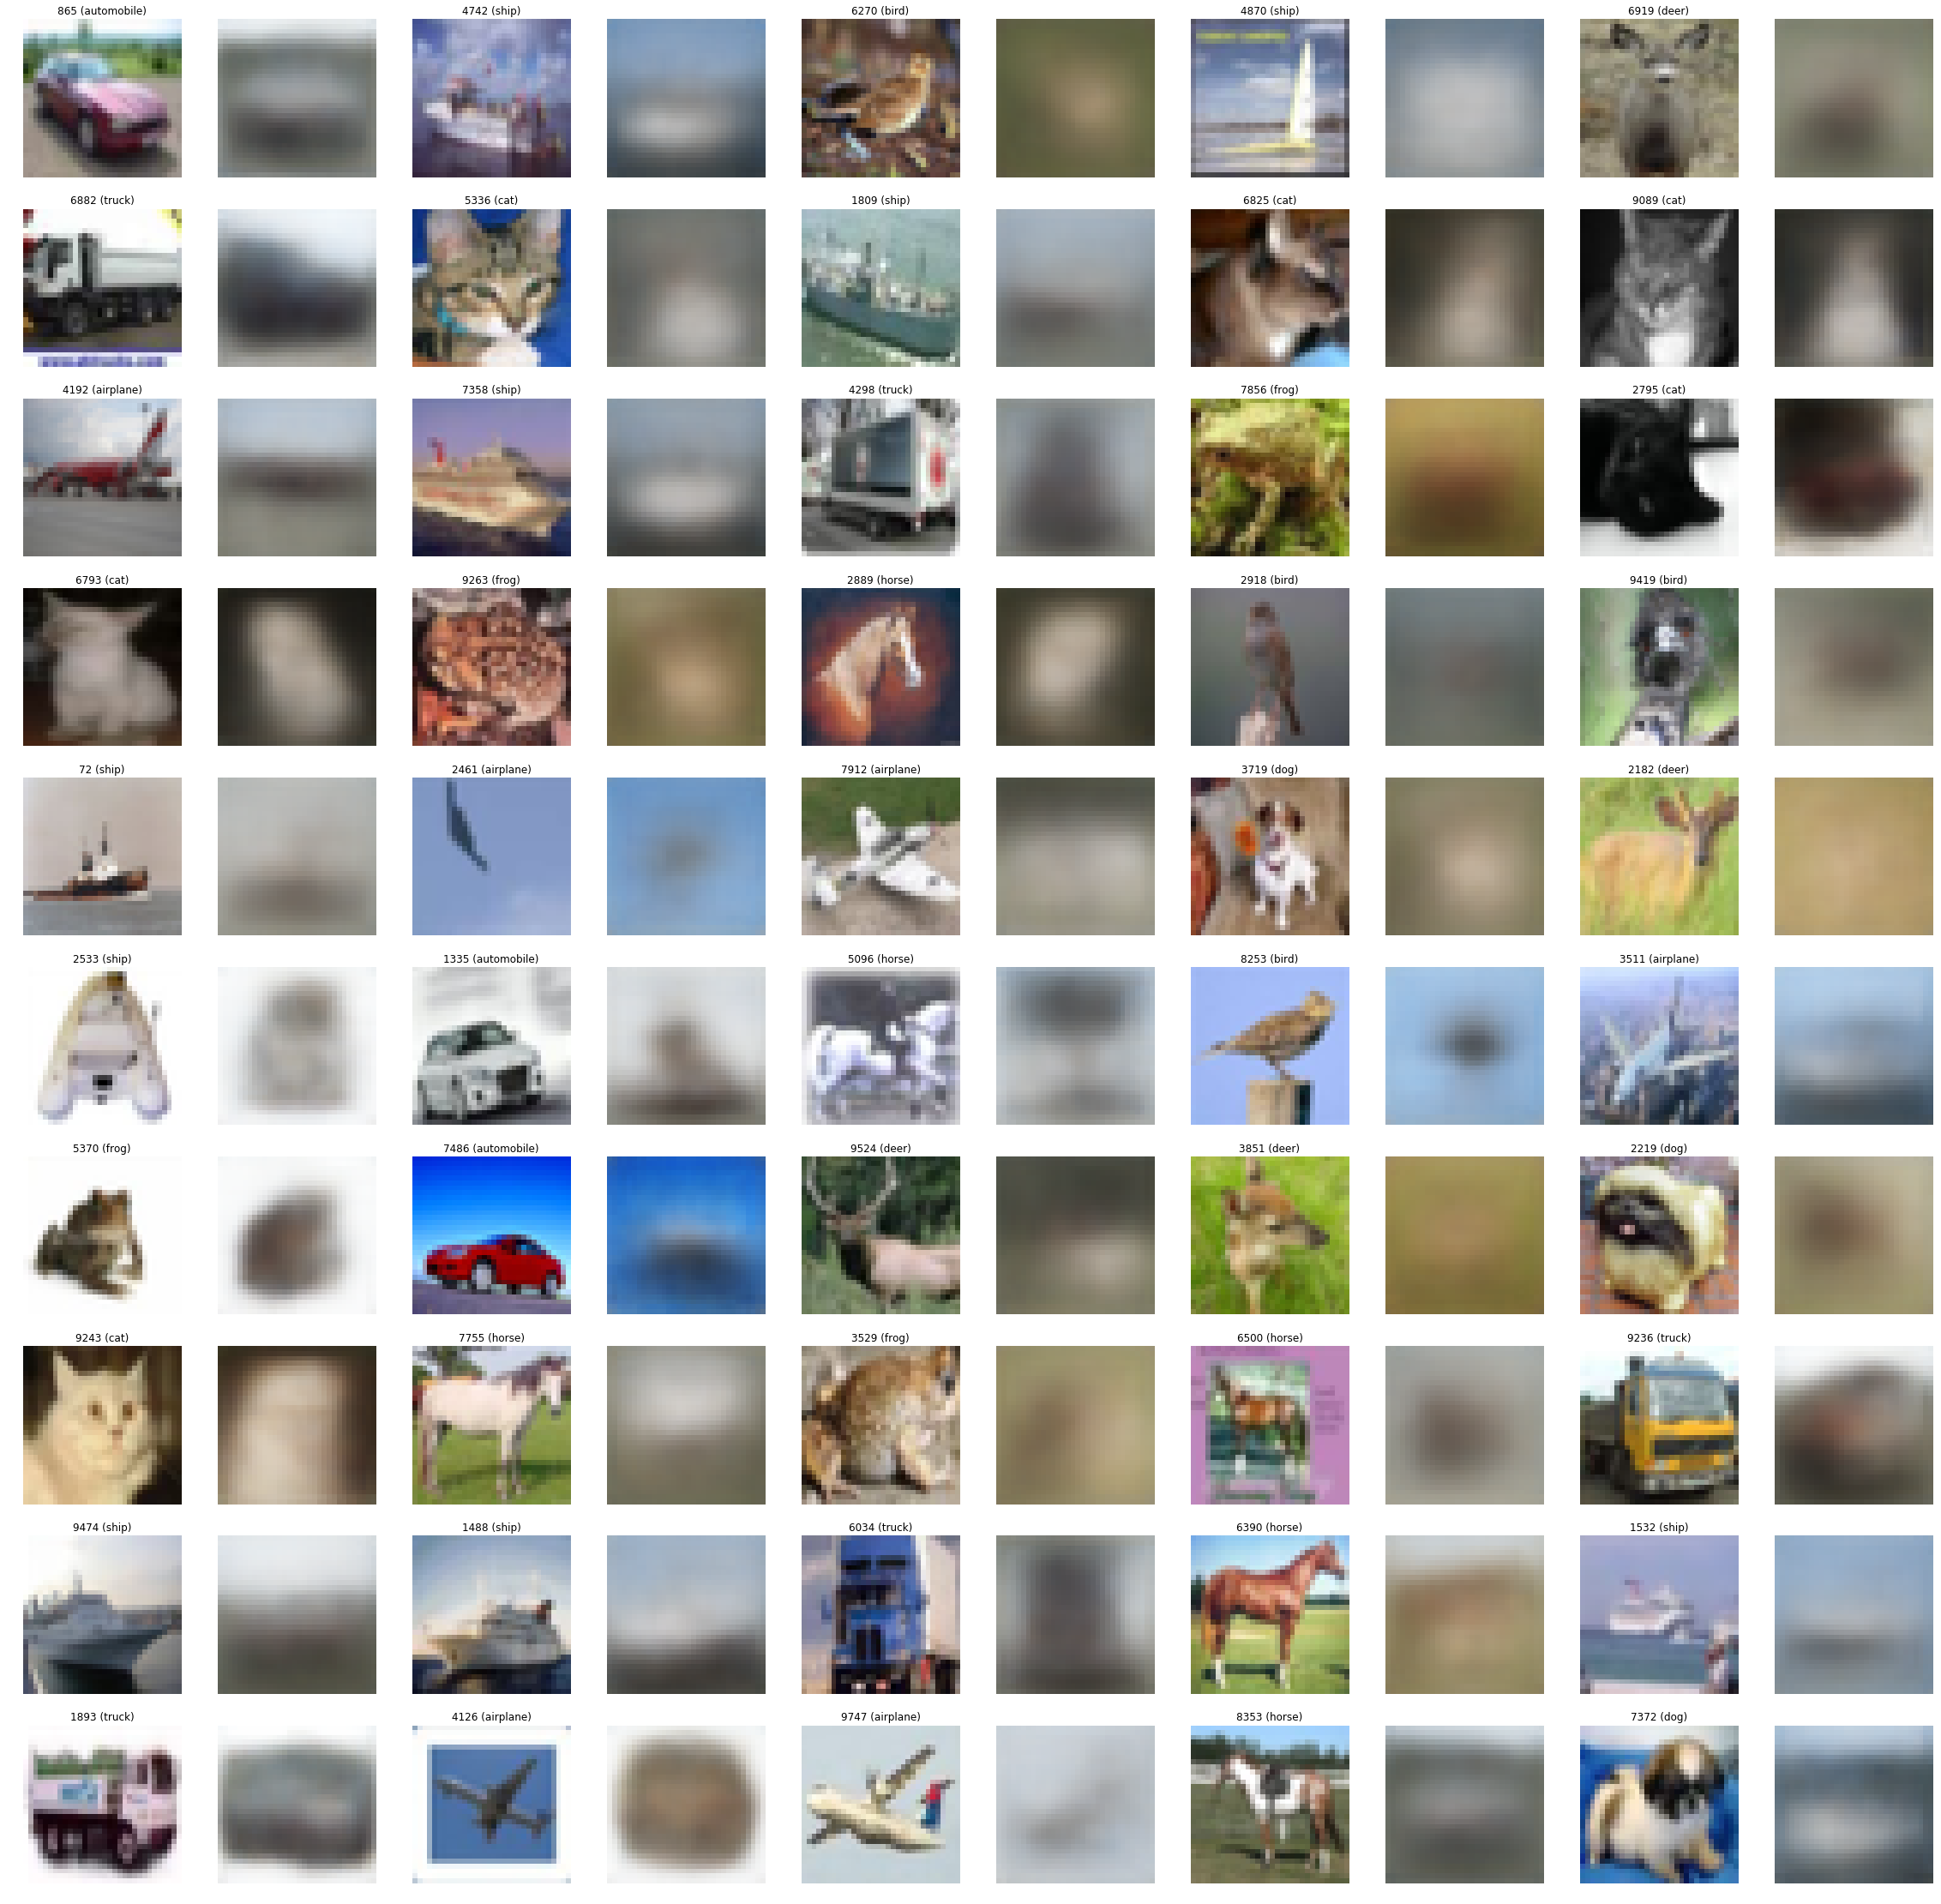

In [9]:
axes_mat = subplots(10, 10).reshape(50, 2)

idxs = np.random.choice(dataset.test_size, len(axes_mat), replace=False)

for axes, idx in zip(axes_mat, idxs):
    test_idx = dataset.test[idx]
    img, y, label = dataset[test_idx]
    img = img.to(device).unsqueeze(0)
    rec_img = vae(img)[0][0].detach()
    
    imshow(img[0].detach(), axes[0])
    axes[0].set_title('%d (%s)' % (idx, label))
    imshow(rec_img, axes[1])

We'll use the embedding norm as a measure of the likelihood of a code belonging to the manifold.

Let's analyze then the norm distribution:

In [10]:
codes = []
ys = []

for X, y, _ in dataset.train_loader:
    X = X.to(device)
    
    code, _ = vae.encode(X)
    codes.append(code.detach()); ys.append(y)
    
codes = torch.cat(codes)
ys = torch.cat(ys)
ys = ys.cpu().detach().numpy().astype(int)

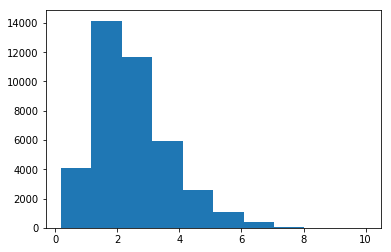

In [11]:
norms = codes.norm(p=2, dim=1).cpu().detach().numpy()
plt.hist(norms);

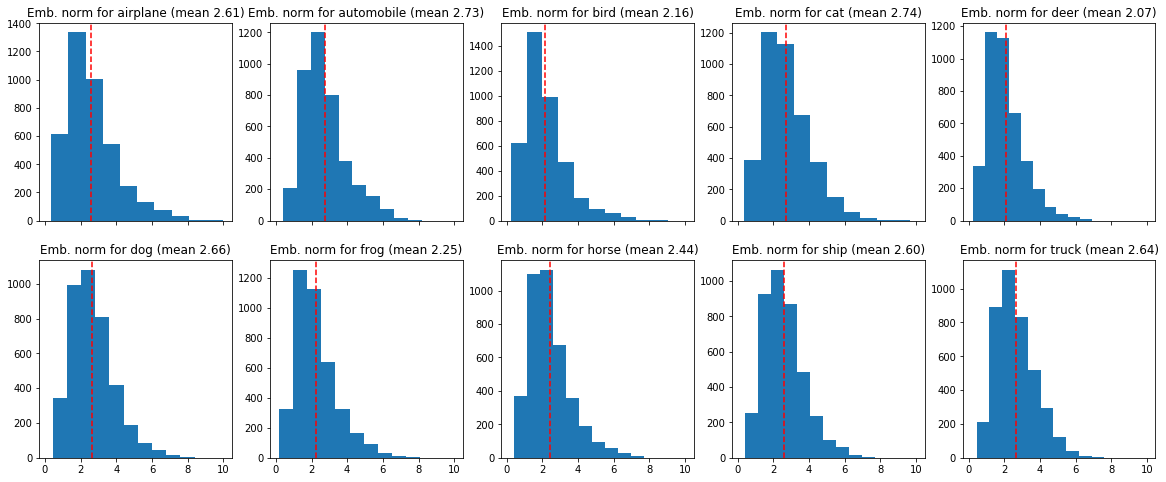

In [12]:
axes = subplots(2, 5, sharex=True).flatten()
class_means = {}

for y, ax in enumerate(axes):
    subset = norms[ys == y]
    norm_mean = subset.mean()
    class_means[int(y)] = float(norm_mean)
    
    ax.hist(subset)
    ax.axvline(norm_mean, linestyle='dashed', color='red')
    ax.set_title('Emb. norm for %s (mean %.2f)' % (dataset.classes[y], norm_mean))
    
class_means[-1] = float(norms.mean())

This is clearly not a normal distribution, even if we split by class. In any case, we'll still work by that assumption for the sake of simplicity.

In [13]:
class_means

{-1: 2.4912850856781006,
 0: 2.6101953983306885,
 1: 2.729870319366455,
 2: 2.158782958984375,
 3: 2.7399818897247314,
 4: 2.073763132095337,
 5: 2.661778211593628,
 6: 2.2494266033172607,
 7: 2.4380884170532227,
 8: 2.6006975173950195,
 9: 2.6446571350097656}

In [14]:
import json

with open('data/cifar10_conv_vae_norm_means.json', 'w') as f:
    json.dump(class_means, f)